### Image Analysis : Automatic Blurred photo detection

We observed that people with visual impairments struggles with taking photos. Often their photos are out of focus and blurry. Using OpenCV, we can detect blurry images. From the responses we have an estimation that some photos are very blurry and can not be recognizable by human. If the system can early detect the blurry photos and asks the user to retake the photos it could reduce human effort. In this analysis, our task is if we can automatically identify the blurred images. 

#### Blurry Image Detection

The following code analyzes the images and tried to detect the blurry images. We manually selected some photos and used OpenCv approaches to detect blurry image. Although, there are some false negatives we decided to use threshold 150. Some examples are given below:

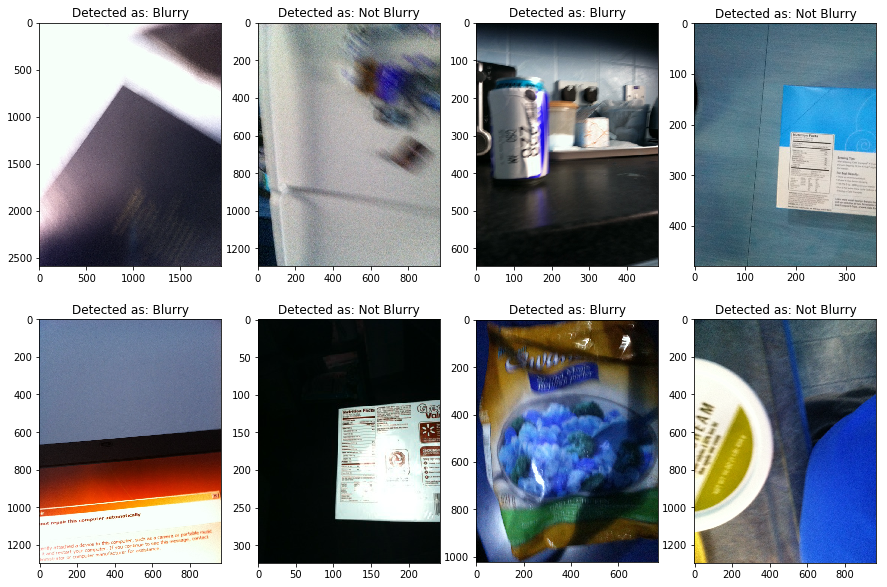

In [91]:
# import the necessary packages
#from imutils import paths
import argparse
import cv2
import os, os.path
import numpy as np
from matplotlib import pyplot as plt

# Plot inline
%matplotlib inline

# Took Help from this link: https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def blur_detection(name) :
    #print name
    image = cv2.imread(name)
    #image=fix_image_size(image)
   # print len(image.shape)
    if image is not None:
        if len(image.shape)==3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        return image,fm
    return None,False

path=os.getcwd()+'/blurry/'
images=[]
for name in os.listdir(path):
    if ".jpg" in name:
        images.append(path+name)
n=len(images)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
for i,name in enumerate(images):
    
    image,score= blur_detection(name)
    text="Blurry" if score<150 else "Not Blurry"
    ax1 = fig.add_subplot(2, n/2,i+1)
    ax1.title.set_text("Detected as: "+text)
   
    ax1.imshow(image)


#### Setting Up Ground Truth

We first need to set up a ground truth to test the accuracy of blurred photo detection. We set up the ground truth from the web workers responses. If any of the web workers mentioned that the image is blurry, then we set the image as blurry. From that, we found a list of 3580 images which can be considered as blurry. We then divided the data frame into two different sets: blurred set and not blurred set. 

In [134]:
import json
import pandas as pd
data = json.load(open('train.json'))

dataframe=pd.DataFrame.from_dict(data)
dataframe=dataframe.drop("private",1)
dataframe['blurred']=False


blurry_images=[]
for index, row in dataframe.iterrows():
    #print index
    #row['blurred']=False
    if row['responses']:
        for ans in row['responses']:
            if "blur" in ans['text'].lower():
                blurry_images.append(row['image'])
                dataframe.set_value(index, 'blurred', True)
                break
dataframe.head(10)
print dataframe['blurred'].value_counts()
#print len(blurry_images)

False    29963
True      3580
Name: blurred, dtype: int64


#### Testing the accuracy

We made an assumption for the accuracy of blur detection. If we consider the real case scenario, if the user need to take a photo more than once to avoid blurring that is not a problem. Although, they have difficulties of taking photos but it is still possible to take a better photo and there is no cost of taking photos. However, if we send a blurry photo to web worker it wastes resources. The system need to pay the web workers for their tasks and the system somehow charges that money to the users. Therefore, taking a blurry photo is costly. Therefore, for such a system it is better to be some false positives than false negatives. Therefore, this system tries to reduce the false negatives. Hence, we tried to improve the recall. However, too much false positive can affect the usability of a system. Therefore,Our target is to find the best accuracy over blurred images minimizing false positive rates. F1 score will help us to find a correct threshold.

In [136]:
## This function takes time to run
## Change the image path to train
path="/Users/tousifeshan/Desktop/train/"
#path=os.getcwd()+'/blurry/'
images=[]
b_o=[]
threshold=150
for index, row in dataframe.iterrows():
    
    image,score=blur_detection(path+row['image'])
    if image is not None:
        #print name, blur
        new_dict={}
        new_dict['image']=row['image']
        new_dict['score']=score
        new_dict['original']=row['blurred']
        new_dict['output']=score<threshold
        b_o.append(new_dict)

b_df=pd.DataFrame.from_dict(b_o)
b_df.head(10)

,image,original,output,score
0,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRip3YQBDA.jpg,False,False,274.512399
1,ag12aXp3aXotc29jaWFscg0LEgVRdWVyeRjl_kcM.jpg,False,False,1127.727542
2,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRjz_4YBDA.jpg,False,False,693.001652
3,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRjz9bIBDA.jpg,False,True,18.725836
4,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRjxuY0BDA.jpg,True,True,0.000000
5,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRiC5ZQDDA.jpg,False,True,30.033341
6,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRj726ICDA.jpg,False,True,103.594599
7,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRi--f4BDA.jpg,False,False,430.187316
8,ag12aXp3aXotc29jaWFscg0LEgVRdWVyeRid6ycM.jpg,False,True,113.387950
9,ag12aXp3aXotc29jaWFscg4LEgVRdWVyeRiD7IEBDA.jpg,False,False,327.611707


In this case, The F1 socres is 0.214. We need to improve the recall by changing the threshold. 

In [174]:
def calculate_f1(df):
    b_img=df[df['original']== True]
    b_match=(b_img['original']==b_img['output'])

    nb_img=df[df['original']== False]
    nb_match=(nb_img['original']==nb_img['output'])
    
    counts= b_match.value_counts().to_dict()
    tp= counts[True] if True in counts  else 0
    fn= counts[False] if False in counts else 0
    
    counts= nb_match.value_counts().to_dict()
    fp= counts[False] if False in counts else 0
    tn= counts[True] if False in counts else 0
    p,r= tp/((1.0)*(tp+fp)),tp/((1.0)*(tp+fn))
   # print tp,fp,fn,p,r
    return (2*(p*r)/(p+r))
    #return counts[1]/(1.0*(counts[1]+counts[0]))
print calculate_f1(b_df)


0.213756045137


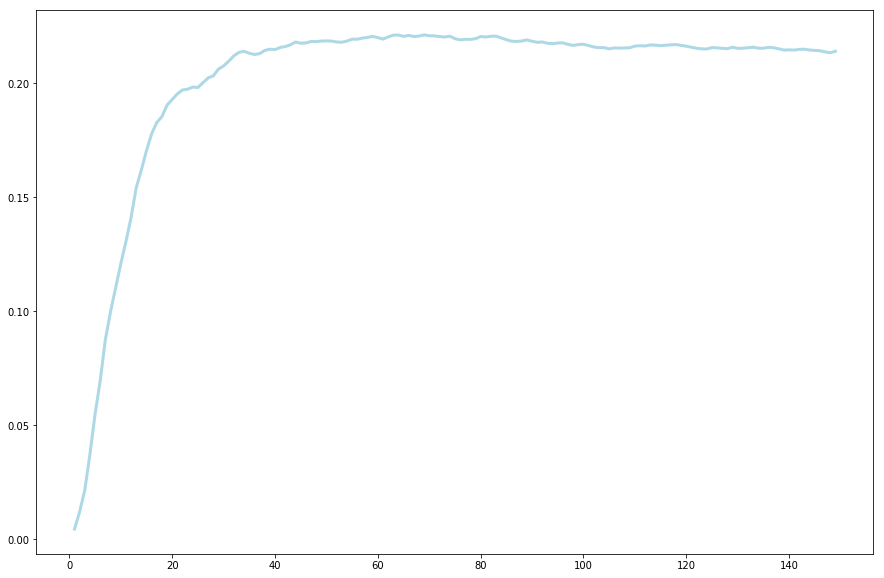

In [179]:
threshold=[]
f_s=[]

for t in range(1,150,1):
    new_dt=[]
    for dt in b_o:
        new_dict={}
        new_dict['image']=dt['image']
        new_dict['original']=dt['original']
        new_dict['output']=dt['score']<t
        new_dt.append(new_dict)
    df2=pd.DataFrame.from_dict(new_dt)
    #print df2
    threshold.append(t)
    rc=calculate_f1(df2)
    #print rc
    f_s.append(rc)

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax = fig.add_subplot(111)
ax.plot(threshold,f_s , color='lightblue', linewidth=3)
plt.show()
    
        